<a href="https://colab.research.google.com/github/HarshalGoyal/Special-Topics-2-/blob/main/Paraphrase_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting G-Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import transformers 
import csv
import wandb

In [ ]:
from wandb.keras import WandbCallback

In [ ]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
use_wandb = True
wandb__project_name = "Paraphrase Detection version 2"
wandb__run_name = "BERT_run_2"

In [ ]:
if use_wandb:
  wandb.init(project=wandb__project_name, name=wandb__run_name)

acc,▁▄▆█▁▆
epoch,▁▂▄▅▇█
loss,█▆▄▁▇▃
val_acc,▅▁▆▆█▇
val_loss,▁▇▆▆█▆
acc,0.97293
best_epoch,0
best_val_loss,0.65221
epoch,5
loss,0.07293
val_acc,0.77771


In [ ]:
max_length = 128
batch_size = 32
epochs = 6

labels = [0,1]

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/MRC_Dataset/msr_paraphrase_train.txt',sep='\t', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv('/content/drive/MyDrive/MRC_Dataset/msr_paraphrase_test.txt',sep='\t', quoting=csv.QUOTE_NONE)

In [ ]:
train_df.columns

Index(['Quality', '#1 ID', '#2 ID', '#1 String', '#2 String'], dtype='object')

In [ ]:
train_df.rename(columns={'#1 String':'Sentence_1', '#2 String':'Sentence_2'},inplace= True)
train_df.columns

Index(['Quality', '#1 ID', '#2 ID', 'Sentence_1', 'Sentence_2'], dtype='object')

In [ ]:
test_df.rename(columns={'#1 String':'Sentence_1', '#2 String':'Sentence_2'},inplace= True)
test_df.columns

Index(['Quality', '#1 ID', '#2 ID', 'Sentence_1', 'Sentence_2'], dtype='object')

In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [ ]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f59b9e51790>
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',      

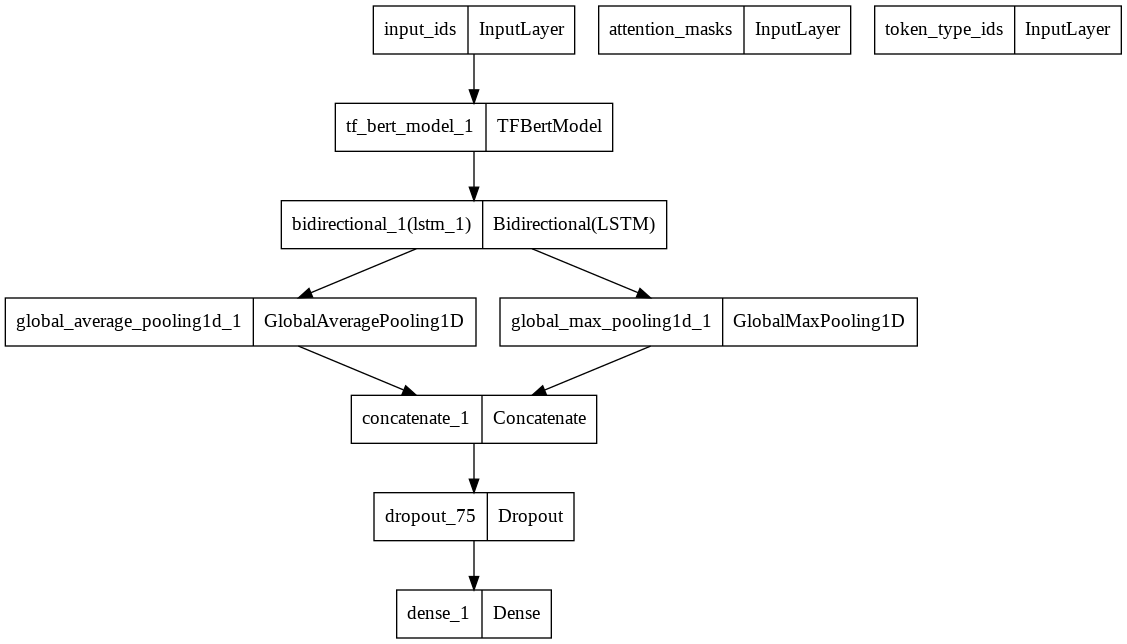

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
y_train = train_df.Quality


y_val = test_df.Quality

y_train_temp = tf.keras.utils.to_categorical(train_df.Quality, num_classes=2)
y_val_temp = tf.keras.utils.to_categorical(test_df.Quality, num_classes=2)

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["Sentence_1", "Sentence_2"]].values.astype("str"),
    y_train_temp,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    test_df[["Sentence_1", "Sentence_2"]].values.astype("str"),
    y_val_temp,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
tf.config.run_functions_eagerly(True)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
    callbacks = [WandbCallback()]
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWa

Epoch 1/6
127/127 [==============================] - ETA: 0s - loss: 0.5980 - acc: 0.6858

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


127/127 [==============================] - 157s 1s/step - loss: 0.5980 - acc: 0.6858 - val_loss: 0.6154 - val_acc: 0.6881 - _timestamp: 1653936103.0000 - _runtime: 170.0000
Epoch 2/6
127/127 [==============================] - 157s 1s/step - loss: 0.5449 - acc: 0.7264 - val_loss: 0.5404 - val_acc: 0.7300 - _timestamp: 1653936261.0000 - _runtime: 328.0000
Epoch 3/6
127/127 [==============================] - 152s 1s/step - loss: 0.4961 - acc: 0.7677 - val_loss: 0.5973 - val_acc: 0.7182 - _timestamp: 1653936415.0000 - _runtime: 482.0000
Epoch 4/6
127/127 [==============================] - 147s 1s/step - loss: 0.4486 - acc: 0.7918 - val_loss: 0.4918 - val_acc: 0.7529 - _timestamp: 1653936560.0000 - _runtime: 627.0000
Epoch 5/6
127/127 [==============================] - 143s 1s/step - loss: 0.4096 - acc: 0.8088 - val_loss: 0.4819 - val_acc: 0.7624 - _timestamp: 1653936704.0000 - _runtime: 771.0000
Epoch 6/6
127/127 [==============================] - 145s 1s/step - loss: 0.3500 - acc: 0.8484 

In [ ]:
model.evaluate(valid_data, verbose=1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


53/53 [==============================] - 19s 345ms/step - loss: 0.4629 - acc: 0.7836


[0.4628789722919464, 0.7836084961891174]

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
ground_truth_class_ids = model.predict(valid_data)
val_predictions = valid_data.labels

In [ ]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = labels[idx]
    if pred == 1:
      return 'paraphrased' 
    else:
      return 'not paraphrased'

In [ ]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWa

'paraphrased'

In [ ]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWa

'paraphrased'

In [ ]:
sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWa

'paraphrased'